In [1]:
from pathlib import Path
from pprint import pformat
import logging
import json
import re
import sys
from math import ceil

import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
import dynamic_yaml
import yaml

logging.basicConfig(format='%(levelname)-8s [%(filename)s] %(message)s',
                    level=logging.INFO)
matplotlib_logger = logging.getLogger("matplotlib")
matplotlib_logger.setLevel(logging.ERROR)
mpl.rcParams[u'font.sans-serif'] = ['simhei']
mpl.rcParams['axes.unicode_minus'] = False

time: 423 ms (started: 2023-02-27 02:42:59 +08:00)


# Find the most differ graph

In [2]:
sys.path.append("/workspace/correlation-change-predict/ywt_library")
current_dir = Path(__file__).parent
data_config_path = current_dir/"../config/data_config.yaml"
with open(data_config_path) as f:
    data = dynamic_yaml.load(f)
    data_cfg = yaml.full_load(dynamic_yaml.dump(data))

# ## Data implement & output setting & testset setting
# data implement setting
data_implement = "SP500_20082017_CORR_SER_REG_CORR_MAT_HRCHY_11_CLUSTER"  # watch options by operate: logging.info(data_cfg["DATASETS"].keys())
# train set setting
train_items_setting = "-train_train"  # -train_train|-train_all
# setting of name of output files and pictures title
output_file_name = data_cfg["DATASETS"][data_implement]['OUTPUT_FILE_NAME_BASIS'] + train_items_setting
# setting of output files
logging.info(f"===== file_name basis:{output_file_name} =====")
graph_data_dir = Path(data_cfg["DIRS"]["PIPELINE_DATA_DIR"])/f"{output_file_name}-graph_data"
graph_arr = np.load(graph_data_dir/f"corr_s1_w10_graph.npy")  # each graph consist of 66 node & 66^2 edges

stride = 12
test_arr = graph_arr[int(len(graph_arr)*0.95):]
test_diff_arr = test_arr[stride:] - test_arr[:-stride] # this is what I want
max_diff_ind = np.argmax(test_diff_arr.sum(axis=1).sum(axis=1))
logging.info(f"test_arr.shape: {test_arr.shape}")
logging.info(f"test_arr[0][0][:5]: \n{test_arr[0][0][:5]}")
logging.info(f"max_difference index of test_arr: {max_diff_ind}")
logging.info(f"test_diff_arr[{max_diff_ind}][0]: \n{test_diff_arr[max_diff_ind][0]}")
logging.info(f"test_arr[{max_diff_ind}][0]: \n{test_arr[max_diff_ind][0]}")
logging.info(f"test_arr[{max_diff_ind+stride}][0]: \n{test_arr[max_diff_ind+stride][0]}")

INFO     [1787420512.py] ===== file_name basis:sp500_20082017_corr_ser_reg_corr_mat_hrchy_11_cluster-train_train =====
INFO     [1787420512.py] test_arr.shape: (125, 66, 66)
INFO     [1787420512.py] test_arr[0][0][:5]: 
[ 1.         -0.43491217  0.95077235  0.85960746  0.9576323 ]
INFO     [1787420512.py] max_difference index of test_arr: 32
INFO     [1787420512.py] test_diff_arr[32][0]: 
[ 0.          0.07539825  0.05752593  0.75535324  0.59607616  0.88995002
  0.74090796  0.18463102  0.68597397  0.54935724  0.86571896  1.13034372
 -0.69026438  1.7631833  -0.1805684   0.09640196 -1.17840275  0.64651908
  0.06263354 -0.41779781  0.2306979   1.7620358   1.00528589 -0.39430222
  1.44330859  1.41865706  0.0763839   0.42584506  0.09158471  0.95326548
  0.95000469  0.84319875  0.82793567  0.07582658 -0.10699536 -1.30089023
 -0.00628975 -0.06328817  0.51558656 -0.92544863 -1.0737499   0.0868318
  1.6201607   1.5498395   0.82878071  0.52726092 -0.07868403 -0.98540224
  1.43846376 -0.30531874 

time: 151 ms (started: 2023-02-27 02:42:59 +08:00)


# Draw the training process

In [3]:
def mts_corr_ad_estimation(log_path_list):
    for log_path in log_path_list:
        with open(log_path, "r") as source:
            log_dict = json.load(source)
            corr_info = [p for p in log_path.parts if p.startswith("corr")][0]
            best_epoch = log_dict['best_val_epoch'] if log_dict.get('best_val_epoch') else 500
            min_val_loss = min(log_dict['val_loss_history'])
            tr_batch = log_dict.get('train_batch') if log_dict.get('train_batch') else None
            batchs_per_epoch = log_dict.get('batchs_per_epoch')
            tr_loss = log_dict.get('train_loss_history')
            val_loss = log_dict.get('val_loss_history')
            pred_embeds = np.array(log_dict.get('graph_embeds_history').get('graph_embeds_pred')[:batchs_per_epoch*2]\
                                   + [[np.nan]*3 for _ in range(20)]\
                                   + log_dict.get('graph_embeds_history').get('graph_embeds_pred')[-batchs_per_epoch*2:])
            y_embeds = np.array(log_dict.get('graph_embeds_history').get('y_graph_embeds')[:batchs_per_epoch*2]\
                                + [[np.nan]*3 for _ in range(20)]\
                                + log_dict.get('graph_embeds_history').get('y_graph_embeds')[-batchs_per_epoch*2:])
            if log_dict.get('model_structure'):
                gin_l = len(re.findall("\(\d\)GINConv", log_dict.get('model_structure')))
                gin_h = re.search("(\(\d\)\:\sGINConv.*\n.*)(out_features\=)(\d*)", log_dict.get('model_structure')).group(3)
                gru_l = re.search("(\(gru1\)\:.*)(num_layers\=)(\d*)", log_dict.get('model_structure'))[0][-1] if re.search("(\(gru1\)\:.*)(num_layers\=)(\d*)", log_dict.get('model_structure')) else 1
                gru_h = re.search("(\(gru1\)\:\sGRU\(\d*\,)\s(\d*)", log_dict.get('model_structure')).group(2)
            else:
                gin_l = None
                gin_h = None
                gru_l = None
                gru_h = None
            logging.info(f"file_name:{log_path.parts}")
        # plot results
        fig, axs = plt.subplots(ncols=2, nrows=6, figsize=(25,50))
        fig.suptitle(f'{corr_info} with tr_batch({tr_batch}) input to model with gin_l{gin_l}-gin_h{gin_h}-gru_l{gru_l}-gru_h{gru_h}; min val-loss:{min_val_loss:8f}', fontsize=30)
        gs = axs[0, 0].get_gridspec()
        # remove the upper axes
        for ncol in range(2):
            for ax in axs[3:, ncol]:
                ax.remove()
        axbig = fig.add_subplot(gs[3:, :2])
        axbig.set_xticks([]); axbig.set_yticks([])
        axbig.annotate(text=f"{log_dict.get('model_structure').__str__()}",
                       xy=(0.15, 0.5), bbox={'facecolor': 'green', 'alpha': 0.4, 'pad': 5},
                       fontsize=20, fontfamily='monospace', xycoords='axes fraction', va='center')
        axs[0, 0].plot(tr_loss)
        axs[0, 1].plot(val_loss)
        axs[1, 0].plot(tr_loss[max(0, best_epoch-100):max(201, best_epoch+101)])
        axs[1, 1].plot(tr_loss[max(0, best_epoch-100):max(201, best_epoch+101)])
        axs[2, 0].plot(pred_embeds, linewidth=5, alpha=0.3)
        axs[2, 0].axvline(x=batchs_per_epoch, ymin=pred_embeds[~np.isnan(pred_embeds)].min(), ymax=pred_embeds[~np.isnan(pred_embeds)].max(),
                          color='k', linewidth=5, linestyle='--', alpha=0.3)
        axs[2, 0].axvline(x=batchs_per_epoch*3+20, ymin=pred_embeds[~np.isnan(pred_embeds)].min(), ymax=pred_embeds[~np.isnan(pred_embeds)].max(),
                          color='k', linewidth=5, linestyle='--', alpha=0.3)
        axs[2, 1].plot(y_embeds, linewidth=5, alpha=0.3)
        axs[2, 1].axvline(x=batchs_per_epoch, ymin=y_embeds[~np.isnan(y_embeds)].min(), ymax=y_embeds[~np.isnan(y_embeds)].max(),
                          color='k', linewidth=5, linestyle='--', alpha=0.3)
        axs[2, 1].axvline(x=batchs_per_epoch*3+20, ymin=y_embeds[~np.isnan(y_embeds)].min(), ymax=y_embeds[~np.isnan(y_embeds)].max(),
                          color='k', linewidth=5, linestyle='--', alpha=0.3)
        axs[0, 0].set_title('train_loss_history', fontsize=30)
        axs[0, 1].set_title('val_loss_history', fontsize=30)
        axs[1, 0].set_title(f"train_loss_history-epoch{(max(0, best_epoch-100), max(200, best_epoch+100))}", fontsize=30)
        axs[1, 1].set_title(f"val_loss_history-epoch{(max(0, best_epoch-100), max(200, best_epoch+100))}", fontsize=30)
        axs[1, 0].set_xticks(ticks=range(0, 201, 20), labels=[f"{x:02d}" for x in range(max(0, best_epoch-100), max(201, best_epoch+101), 20)])
        axs[1, 1].set_xticks(ticks=range(0, 201, 20), labels=[f"{x:02d}" for x in range(max(0, best_epoch-100), max(201, best_epoch+101), 20)])
        for ax in axs.ravel():
            ax.yaxis.offsetText.set_fontsize(30)
            ax.tick_params(axis='both', which='major', labelsize=24)
        fig.tight_layout(rect=(0, 0, 1, 0.97))
        plt.show()
        plt.close()

time: 2.95 ms (started: 2023-02-27 02:43:00 +08:00)


INFO     [2407981061.py] file_name:('save_models', 'sp500_20082017_corr_ser_reg_corr_mat_hrchy_11_cluster-train_train', 'corr_s1_w10', 'train_logs', 'epoch_674-20230227021740.json')


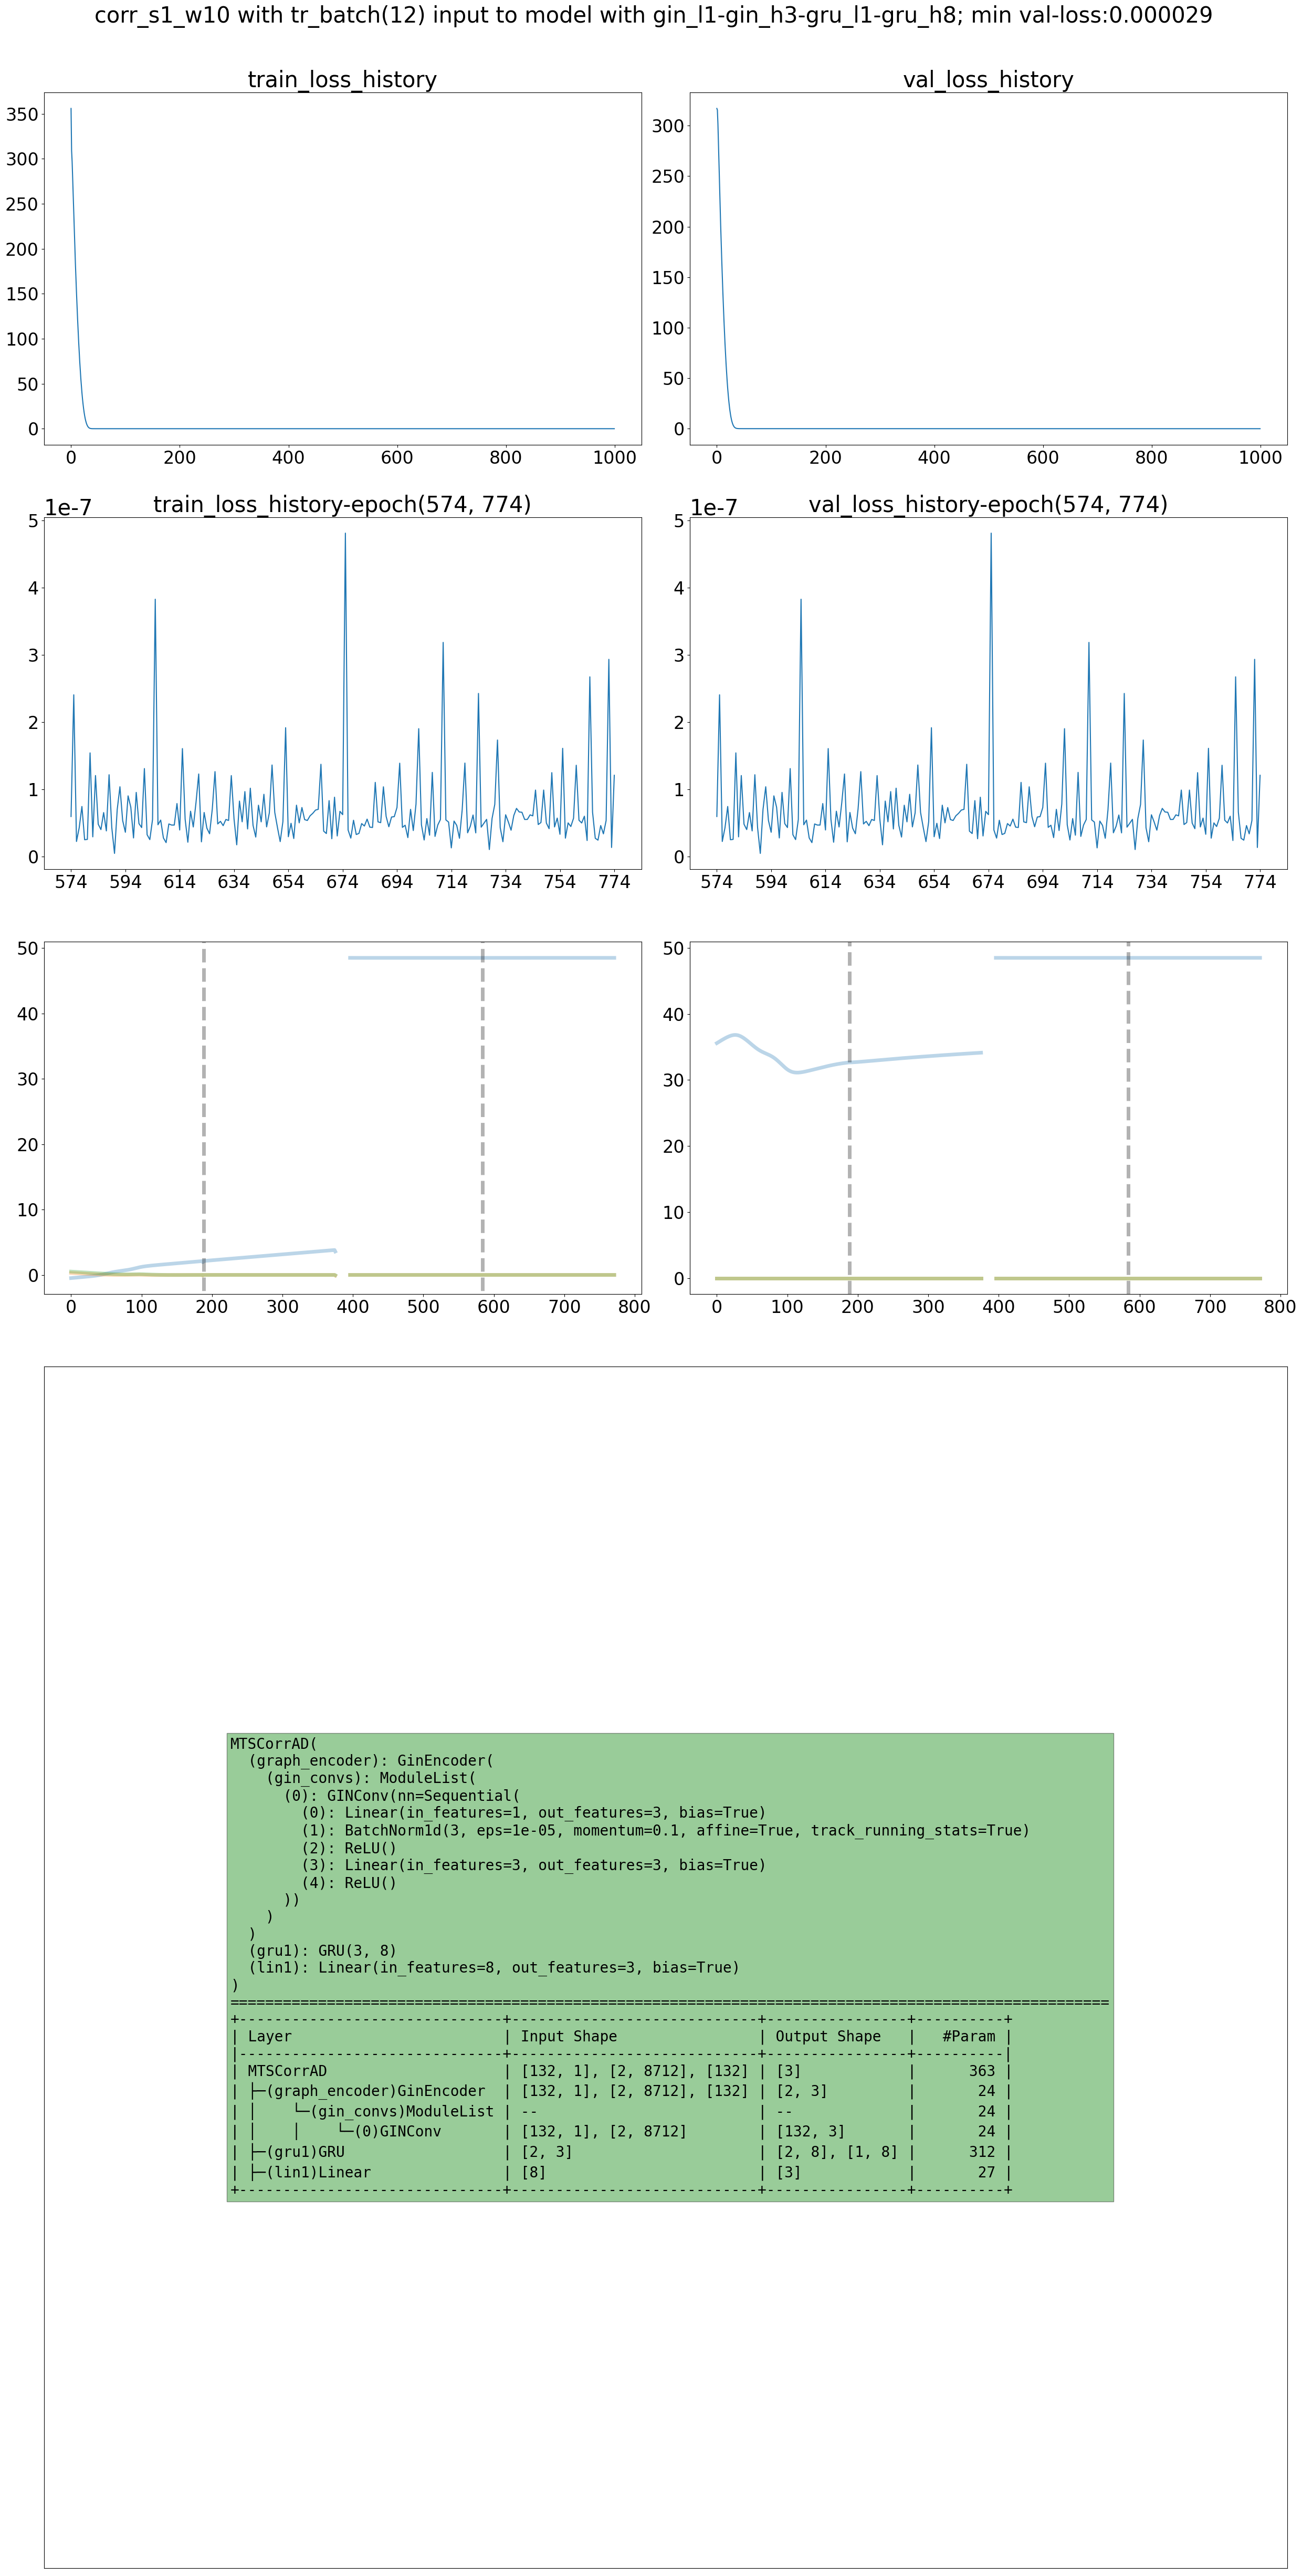

INFO     [2407981061.py] file_name:('save_models', 'sp500_20082017_corr_ser_reg_corr_mat_hrchy_11_cluster-train_train', 'corr_s10_w10', 'train_logs', 'epoch_996-20230227023211.json')


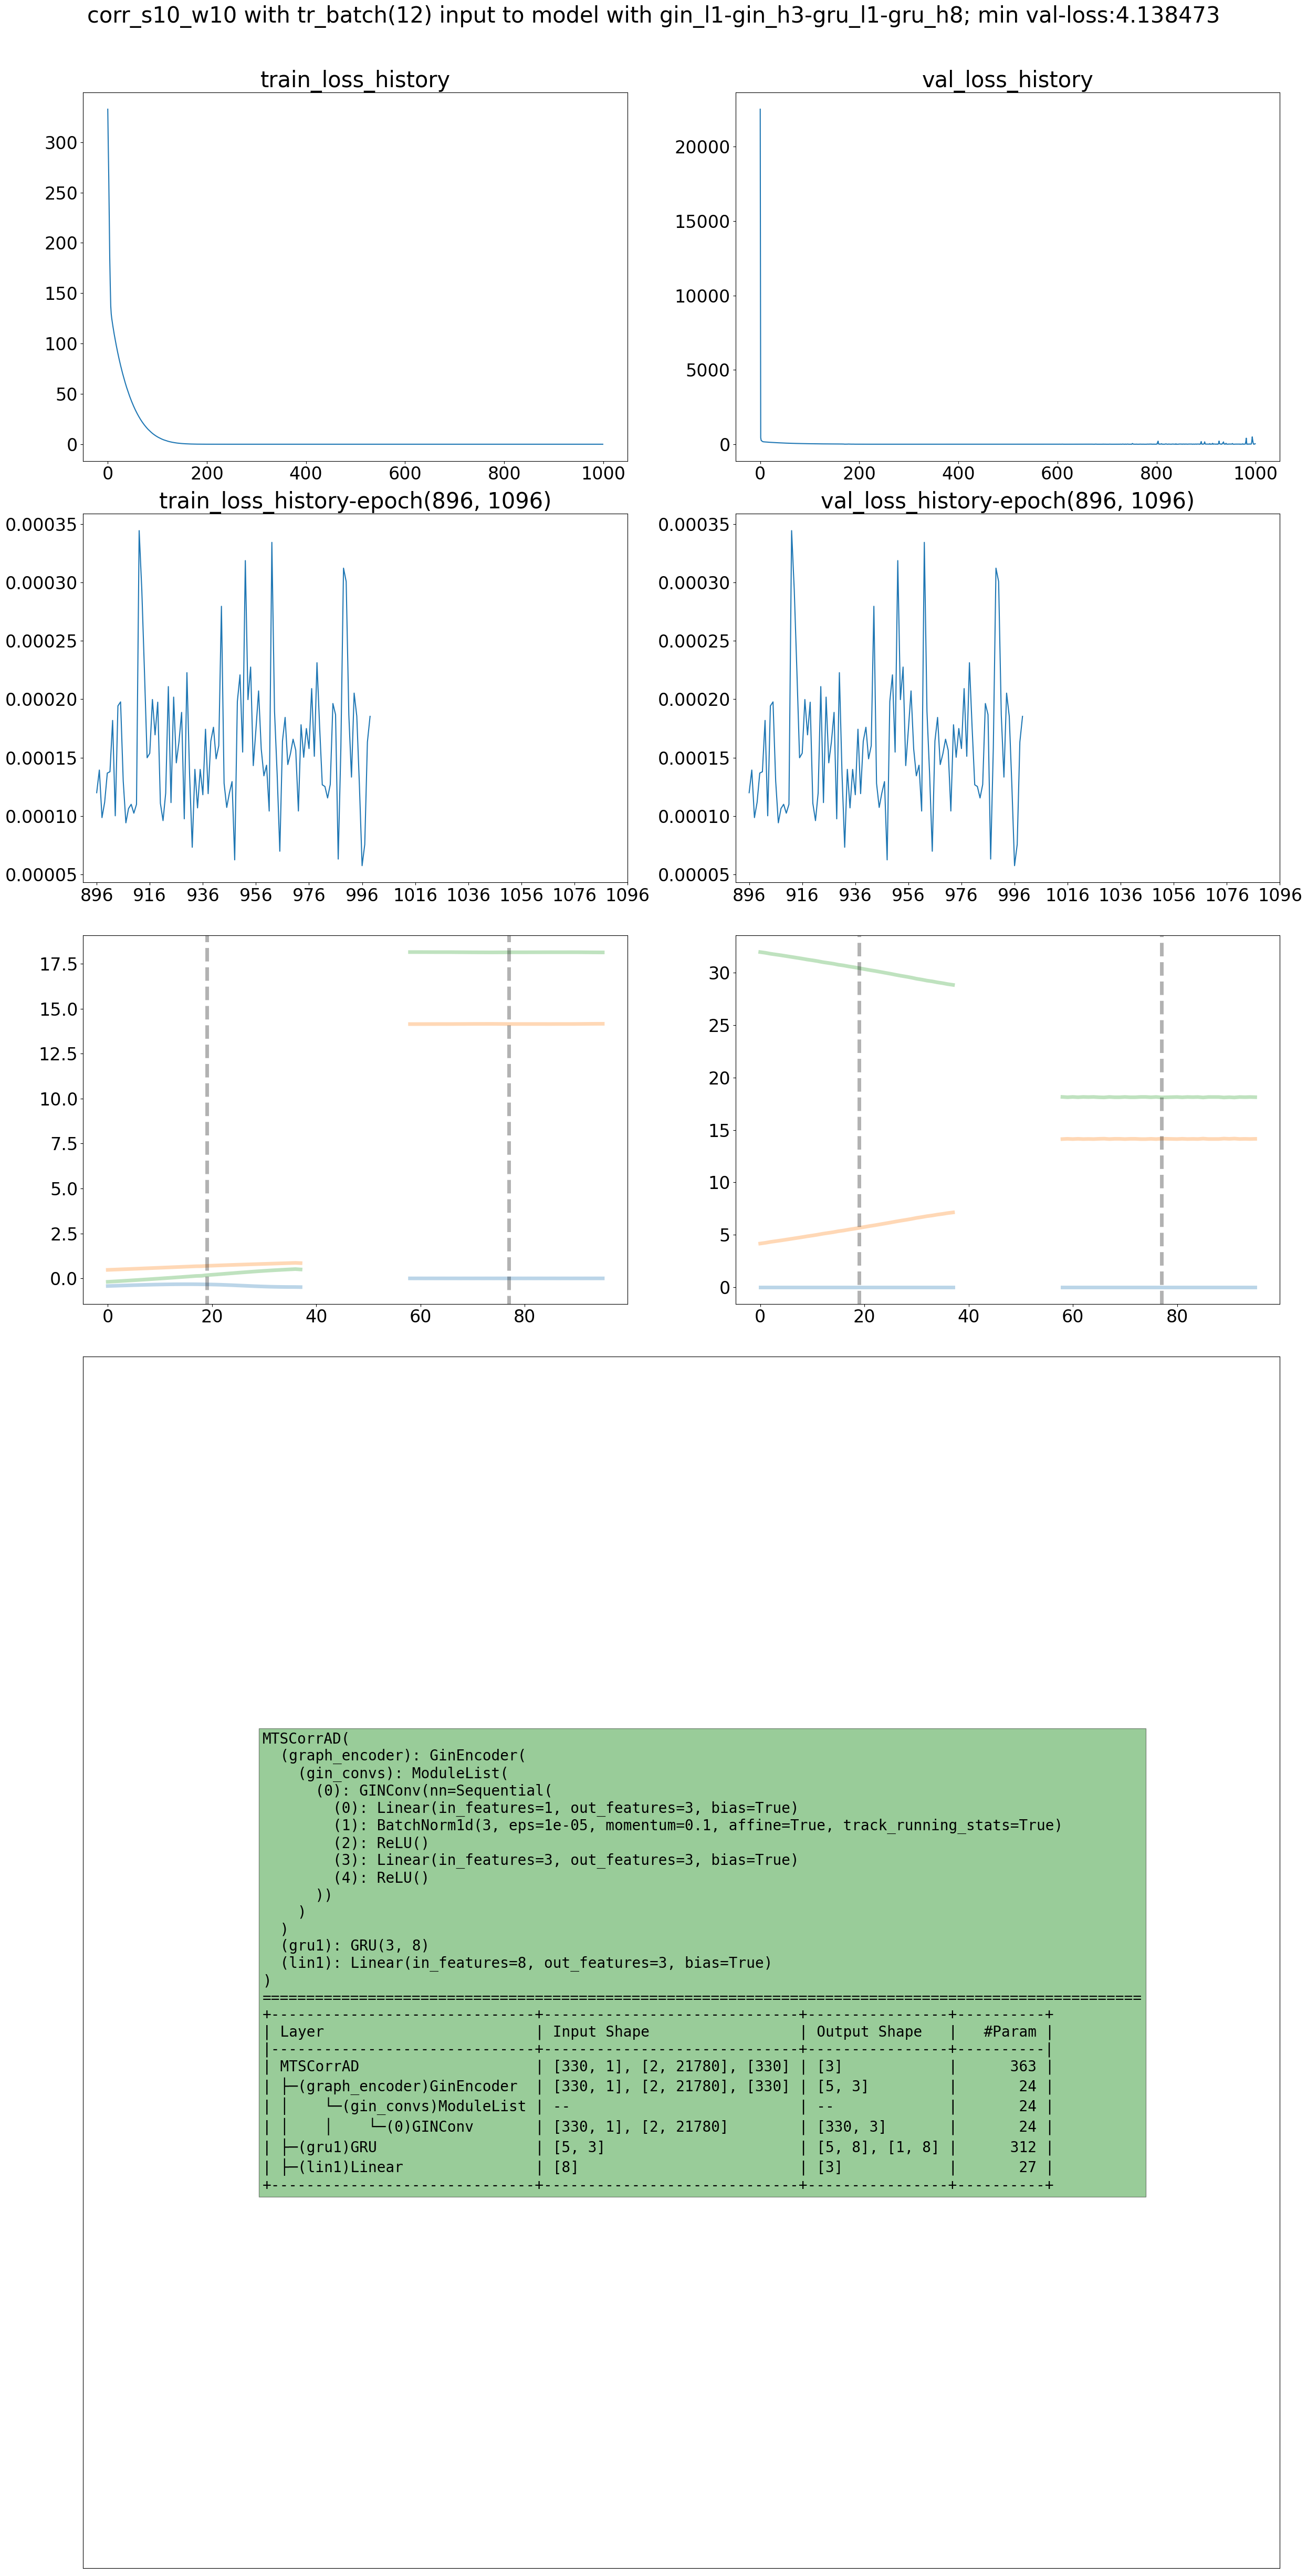

time: 3.07 s (started: 2023-02-27 02:43:00 +08:00)


In [4]:
mts_corr_model_log_dir = Path("./save_models/sp500_20082017_corr_ser_reg_corr_mat_hrchy_11_cluster-train_train/")
# log_path_list = [p for p in mts_corr_model_log_dir.glob("./*[!deprecated][!.ipynb_checkpoints]*/**/*[.json]") if p.is_file()]
log_path_list = mts_corr_model_log_dir.glob("./*[!deprecated][!.ipynb_checkpoints]*/train_logs/*[!.ipynb_checkpoints]*[.json]")
mts_corr_ad_estimation(log_path_list)